In [ ]:
!nvidia-smi

Tue Nov  2 12:11:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drvie')

Mounted at /content/drvie


In [ ]:
from keras.datasets import cifar10
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_input_19
from keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.transform import resize
import seaborn as sns
from keras.models import load_model
from tensorflow.keras.optimizers import SGD
from sklearn.manifold import TSNE
import pickle

**1.1 Import Data**

170508288/170498071 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


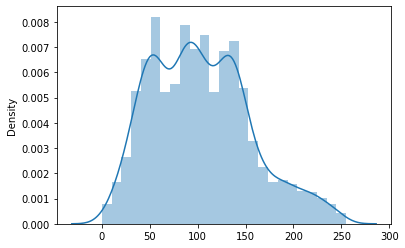

In [ ]:
# load cifar-10 dataset
(x_train, y_train), (x_val, y_val) = cifar10.load_data()
# val test split
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5) 

# dist original data
sns.distplot(x_train[0].reshape(1, -1))

In [ ]:
# preprocessing
x_train = preprocess_input_16(x_train)
x_val = preprocess_input_16(x_val)
x_test = preprocess_input_16(x_test)
# encoding labal
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

In [ ]:
# shape of train-val-test data
print("Shape x_train = {}, y_train = {}".format(x_train.shape, y_train.shape))
print("Shape x_val = {}, y_val = {}".format(x_val.shape, y_val.shape))
print("Shape x_test = {}, y_test = {}".format(x_test.shape, y_test.shape))

Shape x_train = (50000, 32, 32, 3), y_train = (50000, 10)
Shape x_val = (6000, 32, 32, 3), y_val = (6000, 10)
Shape x_test = (4000, 32, 32, 3), y_test = (4000, 1)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


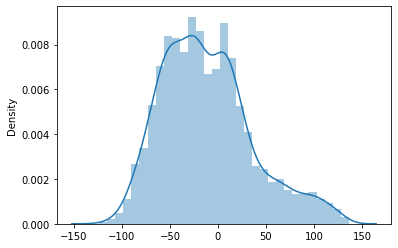

In [ ]:
# data after preprocessing
sns.distplot(x_train[0].reshape(1, -1))

**1.2 VGG16**

In [ ]:
def build_model(base_model):
  # freeze base model
#  base_model.trainable = False
#  for layer in base_model.layers[-2:-1]:
#    layer.trainable = True
  # Dense flatten - 512 - 10 
  flatten = Flatten()(base_model.output)
  dense_01 = Dense(512, 'relu')(flatten)
  #dense_02 = Dense(512, 'relu')(dense_01)
  ouput_layer = Dense(10, 'softmax')(dense_01)
  model = Model(inputs = base_model.inputs, outputs = ouput_layer)
  # setup optimize and training
  model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics= 'categorical_accuracy')
  return model

In [ ]:
def check_point(checkpoint_filepath):
  model_checkpoint_callback=ModelCheckpoint(
  filepath=checkpoint_filepath,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)
  return model_checkpoint_callback

In [ ]:
!mkdir vgg16-keras-32

In [ ]:
# VGG16
base_vgg16 = VGG16(include_top=False, input_shape=(32, 32, 3))
vgg16 = build_model(base_vgg16)
vgg16.summary()

# traing
checkpoint_filepath_vgg16 = './drvie/MyDrive/CS231.M13.KHCL/workingspace/taicv/vgg16-keras-32/best-weights.hdf5'
#checkpoint
model_checkpoint_callback_vgg16 = check_point(checkpoint_filepath_vgg16)

**1.3 Training**

In [ ]:
#training VGG16
vgg16.fit(x_train, y_train, batch_size=512, epochs=20, validation_data=(x_val, y_val), callbacks=[model_checkpoint_callback_vgg16])

In [ ]:
# classification report
y_pre_16 = vgg16.predict(x_test)
y_pre_16 = y_pre_16.argmax(axis=1)
print(classification_report(y_test, y_pre_16))

**2. Load pretrain model and testing**

In [ ]:
# VGG16
pretrain_path = './drvie/MyDrive/CS231.M13.KHCL/workingspace/taicv/vgg16-keras-32/best-weights.hdf5'
base_vgg16_tuning = VGG16(include_top=False, input_shape=(32, 32, 3))
vgg16_tuning = build_model(base_vgg16_tuning)
vgg16_tuning.load_weights(pretrain_path)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# classification report
y_pre_16 = vgg16_tuning.predict(x_test)
y_pre_16 = y_pre_16.argmax(axis=1)
print(classification_report(y_test, y_pre_16))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       402
           1       0.89      0.89      0.89       397
           2       0.77      0.74      0.76       410
           3       0.65      0.66      0.66       396
           4       0.79      0.76      0.77       411
           5       0.81      0.61      0.70       383
           6       0.83      0.89      0.86       390
           7       0.77      0.88      0.82       398
           8       0.83      0.91      0.87       399
           9       0.85      0.88      0.87       414

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000



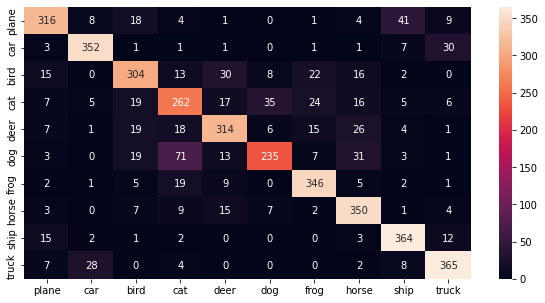

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

classes = ('plane', 'car' , 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
cm = confusion_matrix(y_test, y_pre_16)

df_cm = pd.DataFrame(cm, index = [cls for cls in classes],
                  columns = [cls for cls in classes])
plt.figure(figsize = (10,5))
sn.heatmap(df_cm, annot=True, fmt='g')